### Training an AI agent to play Pong using DQN (based on the DeepMind Paper Human-level control through deep reinforcement learning)

In [2]:
# run only once!
#!pip install "numpy<2.0" tensorflow gymnasium[atari] ale-py opencv-python matplotlib
#!pip uninstall -y tensorflow
#!pip install tensorflow-macos
#!pip install --upgrade tensorflow-metal
#!pip uninstall -y tensorflow-macos
#!pip install --upgrade tensorflow

In [1]:
import random
import collections
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import gymnasium as gym
import ale_py
import tensorflow as tf
import time
from tensorflow import keras
from tensorflow.keras import layers
from ale_py.vector_env import AtariVectorEnv
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import FrameStackObservation
from gymnasium.wrappers import RecordVideo

from IPython.display import display, clear_output



#### Visualising the game

In [1]:
gym.register_envs(ale_py)

# Create a Pong environment with visual rendering for demo
env_vis = gym.make("ALE/Pong-v5", render_mode="rgb_array")

obs, info = env_vis.reset(seed=42)

plt.figure(figsize=(6, 6))
for step in range(100):
    frame = env_vis.render()  # RGB frame from environment

    plt.imshow(frame)
    plt.axis("off")
    display(plt.gcf())
    clear_output(wait=True)

    # Random action just to see movement
    action = env_vis.action_space.sample()
    obs, reward, terminated, truncated, info = env_vis.step(action)

    if terminated or truncated:
        obs, info = env_vis.reset()

env_vis.close()
plt.close()

NameError: name 'gym' is not defined

#### Pre-processsing data, build experience replay, Q-network and epsilon-greedy policy

In [2]:


# ---------- Replay Buffer ----------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert frame from unit8 to float32
        states = np.array(states, dtype=np.uint8).astype(np.float32) / 255.0
        next_states = np.array(next_states, dtype=np.uint8).astype(np.float32) / 255.0
        
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int32),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32),
        )

    def __len__(self):
        return len(self.buffer)


# ---------- Q-network (DQN) ----------
def build_q_network(num_actions):
    model = keras.Sequential([
        # layers.Input(shape=(4, 84, 84)),  # channels-first (C,H,W)

        #layers.Conv2D(32, 8, strides=4, activation="relu", data_format="channels_first"),
        #layers.Conv2D(64, 4, strides=2, activation="relu", data_format="channels_first"),
        #layers.Conv2D(64, 3, strides=1, activation="relu", data_format="channels_first"),

        layers.Input(shape=(84, 84, 4)),  # channels-last (H,W,C)
        layers.Conv2D(32, 8, strides=4, activation="relu"),
        layers.Conv2D(64, 4, strides=2, activation="relu"),
        layers.Conv2D(64, 3, strides=1, activation="relu"),

        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_actions)  # Q-values for each action
    ])
    return model


# ---------- ε-greedy schedule ----------
def epsilon_by_step(step, eps_min=0.1, decay_steps=150_000):
    if step >= decay_steps:
        return eps_min
    frac = step / decay_steps
    return 1.0 + frac * (eps_min - 1.0)  # linear decay from 1.0 -> eps_min


def select_action(model, state, epsilon, num_actions):
    # state: (4,84,84)
    if random.random() < epsilon:
        return random.randrange(num_actions)
    state_tf = tf.convert_to_tensor(state[None, ...], dtype=tf.float32)  # (1,4,84,84)
    # state_tf = tf.expand_dims(tf.convert_to_tensor(state, tf.float32), 0) # (1,84,84,4)
    q_values = model(state_tf, training=False)[0]  # (num_actions,)
    return int(tf.argmax(q_values).numpy())

class ChannelsLast(gym.ObservationWrapper):
    def observation(self, obs):
        # (4,84,84) -> (84,84,4)
        # obs = np.asarray(obs)           # convert LazyFrames -> ndarray
        return np.transpose(obs, (1, 2, 0))

def initialise_environment(env_name = "ALE/Pong-v5", record_video = False, video_name_prefix=""):
    
    if record_video:
        # Create Pong env for recording
        env = gym.make(env_name, render_mode="rgb_array", frameskip=1)
        env = RecordVideo(
            env.unwrapped,
            video_folder="./videos",
            episode_trigger=lambda e: True,
            name_prefix=video_name_prefix
        )
    else:    
        # Create Pong env for training (no rendering here)
        env = gym.make(env_name, render_mode=None, frameskip=1, full_action_space=False)
    
    env = AtariPreprocessing(env, noop_max=30, frame_skip=4, screen_size=84, grayscale_obs=True, scale_obs=False)
    env = FrameStackObservation(env, stack_size=4)
    env = ChannelsLast(env)
    return env



#### Train agent

In [3]:
start_time = time.time()

# Create an environment for training
env = initialise_environment(env_name = "ALE/Pong-v5")
state, info = env.reset(seed=42)
num_actions = env.action_space.n

# Build networks and components
q_net = build_q_network(num_actions)
target_net = build_q_network(num_actions)
target_net.set_weights(q_net.get_weights())

optimizer = keras.optimizers.AdamW(learning_rate=1e-4)
optimizer.build(q_net.trainable_variables)

huber = tf.keras.losses.Huber()

@tf.function
def train_step(states_tf, actions_tf, rewards_tf, next_states_tf, dones_tf):
    with tf.GradientTape() as tape:
        q_values = q_net(states_tf, training=True)
        q_s_a = tf.reduce_sum(q_values * tf.one_hot(actions_tf, num_actions), axis=1)
        
        max_next_q = tf.reduce_max(target_net(next_states_tf, training=False), axis=1)
        targets = tf.stop_gradient(rewards_tf + GAMMA * (1.0 - dones_tf) * max_next_q)

        loss = huber(targets, q_s_a)

    grads = tape.gradient(loss, q_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, q_net.trainable_variables))
    return loss


replay_buffer = ReplayBuffer(capacity=100_000)

GAMMA = 0.99
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = 1_000   # steps
WARMUP_STEPS = 10_000        # collect some data before learning
TOTAL_STEPS = 1_000_001        # increase later for better results

# Save the model after this many steps
save_model_steps = {0, 50_000, 100_000, 250_000, 500_000, 750_000, 1_000_000}

episode_reward = 0.0
episode_rewards = []
episode_end_steps = []

step_time = 0.0
sample_time = 0.0
dqn_update_time = 0.0


for step in range(TOTAL_STEPS):
    # ---- ε-greedy action selection ----
    epsilon = epsilon_by_step(step)
    action = select_action(q_net, state, epsilon, num_actions)

    # ---- env step ----
    t0 = time.time()
    
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # next_frame = next_state[-1]  # get the last stacked frame
    # next_frame = next_state[:, :, -1]   # shape (84,84)

    # ---- store transition ----
    replay_buffer.push(state, action, float(reward), next_state, float(done))
    state = next_state
    episode_reward += reward

    step_time += time.time() - t0

    # ---- handle episode end ----
    if done:
        state, info = env.reset()
            
        episode_rewards.append(episode_reward)
        episode_end_steps.append(step)
        print(f"[Step {step}] Episode finished, reward = {episode_reward}")
        episode_reward = 0.0

    # ---- save the model at certain check point ----
    if step in save_model_steps:            
        q_net.save(f"pong_dqn fix9 ({step} steps).keras")

    # ---- warmup: no learning yet ----
    if step < WARMUP_STEPS or len(replay_buffer) < BATCH_SIZE:
        continue

    #w0 = [v.numpy().copy() for v in q_net.trainable_variables]
    #loss = train_step(states_tf, actions_tf, rewards_tf, next_states_tf, dones_tf)
    #max_delta = max(float(tf.reduce_max(tf.abs(v - w)).numpy())
    #                for v, w in zip(q_net.trainable_variables, w0))
    #print("loss:", float(loss.numpy()), "max |Δw|:", max_delta)

    # ---- sample minibatch ----
    t0 = time.time()
    states_b, actions_b, rewards_b, next_states_b, dones_b = replay_buffer.sample(BATCH_SIZE)
    sample_time += time.time() - t0

    t0 = time.time()

    # tf.config.run_functions_eagerly(False)
    states_tf      = tf.convert_to_tensor(states_b, tf.float32)
    actions_tf     = tf.convert_to_tensor(actions_b, tf.int32)
    rewards_tf     = tf.convert_to_tensor(rewards_b, tf.float32)
    next_states_tf = tf.convert_to_tensor(next_states_b, tf.float32)
    dones_tf       = tf.convert_to_tensor(dones_b, tf.float32)
    
    loss = train_step(states_tf, actions_tf, rewards_tf, next_states_tf, dones_tf)
    #w_outside = tf.reduce_sum(q_net.trainable_variables[0][0:1])
    
    #print("inside:", float(w_inside.numpy()), "outside:", float(w_outside.numpy()))
    #print("abs diff:", float(tf.abs(w_inside - w_outside).numpy()))
    """
    states_tf      = tf.convert_to_tensor(states_b, dtype=tf.float32)
    next_states_tf = tf.convert_to_tensor(next_states_b, dtype=tf.float32)
    actions_tf     = tf.convert_to_tensor(actions_b, dtype=tf.int32)
    rewards_tf     = tf.convert_to_tensor(rewards_b, dtype=tf.float32)
    dones_tf       = tf.convert_to_tensor(dones_b, dtype=tf.float32)

    # ---- DQN update ----
    with tf.GradientTape() as tape:
        q_values = q_net(states_tf, training=True)
        action_one_hot = tf.one_hot(actions_tf, num_actions)
        q_s_a = tf.reduce_sum(q_values * action_one_hot, axis=1)

        target_q_values = target_net(next_states_tf, training=False)
        max_next_q = tf.reduce_max(target_q_values, axis=1)

        # targets = rewards_tf + GAMMA * (1.0 - dones_tf) * max_next_q
        targets = tf.stop_gradient(rewards_tf + GAMMA * (1.0 - dones_tf) * max_next_q)
        # loss = tf.reduce_mean(tf.square(q_s_a - targets))
        loss = tf.reduce_mean(tf.keras.losses.Huber()(targets, q_s_a))
        
    grads = tape.gradient(loss, q_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, q_net.trainable_variables))
    """
   
    dqn_update_time += time.time() - t0
    
    # ---- periodically update target network ----
    if step % TARGET_UPDATE_FREQ == 0:
        target_net.set_weights(q_net.get_weights())
        print(f"[Step {step}] loss = {loss.numpy():.4f}, epsilon = {epsilon:.3f}")

            

env.close()

# ---------- SAVE TRAINED MODEL + LOGS ----------
q_net.save("pong_dqn.keras")
np.save("pong_episode_rewards fix9.npy", np.array(episode_rewards))
np.save("pong_episode_end_steps fix9.npy", np.array(episode_end_steps))

# --------- PRINT TIME TAKEN ------------
end_time = time.time()
total_seconds = end_time - start_time

hours = int(total_seconds // 3600)
minutes = int((total_seconds % 3600) // 60)
seconds = int(total_seconds % 60)

print("TRAINING COMPLETE")
print(f"Time Taken: {hours}h {minutes}m {seconds}s")
print("===================================")
print(f"step_time {step_time}, sample_time {sample_time}, dqn_update_time {dqn_update_time}")

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


[Step 822] Episode finished, reward = -21.0
[Step 1685] Episode finished, reward = -20.0
[Step 2722] Episode finished, reward = -19.0
[Step 3651] Episode finished, reward = -21.0
[Step 4691] Episode finished, reward = -20.0
[Step 5525] Episode finished, reward = -20.0
[Step 6471] Episode finished, reward = -20.0
[Step 7303] Episode finished, reward = -21.0
[Step 8239] Episode finished, reward = -19.0
[Step 9193] Episode finished, reward = -20.0
[Step 10000] loss = 0.0015, epsilon = 0.940
[Step 10093] Episode finished, reward = -20.0
[Step 10930] Episode finished, reward = -21.0
[Step 11000] loss = 0.0001, epsilon = 0.934
[Step 11870] Episode finished, reward = -21.0
[Step 12000] loss = 0.0320, epsilon = 0.928
[Step 12678] Episode finished, reward = -21.0
[Step 13000] loss = 0.0014, epsilon = 0.922
[Step 13659] Episode finished, reward = -20.0
[Step 14000] loss = 0.0002, epsilon = 0.916
[Step 14506] Episode finished, reward = -21.0
[Step 15000] loss = 0.0009, epsilon = 0.910
[Step 15496

### Generate plot to visualize

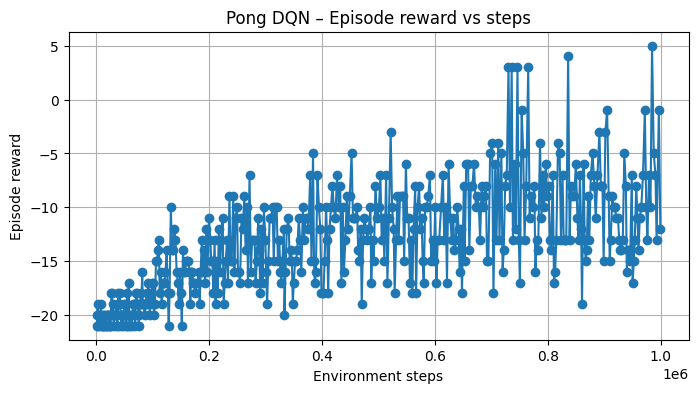

In [4]:
# episode_rewards = np.load("pong_episode_rewards.npy").tolist() - to access later
# episode_end_steps = np.load("pong_episode_end_steps.npy").tolist()


episode_rewards_arr = np.array(episode_rewards)
episode_end_steps_arr = np.array(episode_end_steps)

plt.figure(figsize=(8, 4))
plt.plot(episode_end_steps_arr, episode_rewards_arr, marker="o", linestyle="-")
plt.xlabel("Environment steps")
plt.ylabel("Episode reward")
plt.title("Pong DQN – Episode reward vs steps")
plt.grid(True)
plt.show()

### Save videos based on model checkpoints

In [7]:
# For each model checkpoint
for step in sorted(save_model_steps):

    # Load the saved network
    
    file_name = f"pong_dqn ({step} steps)"
    try:
        print("Saving video for " + file_name)
        q_net = keras.models.load_model(f"{file_name}.keras")
    
        # Initialise the environment for rendering
        env = initialise_environment(record_video = True, video_name_prefix=file_name)
        state, info = env.reset()
        num_actions = env.action_space.n
        
        # Record a video of the network
        done = False
        total_reward = 0
        
        while not done:
            # Greedy policy from trained agent
            action = select_action(q_net, state, epsilon=0.0, num_actions=num_actions)
        
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
                    
        env.close()

    except ValueError:
        print("Couldn't load " + file_name)
        break

Saving video for pong_dqn (0 steps)
Saving video for pong_dqn (50000 steps)
Saving video for pong_dqn (100000 steps)
Saving video for pong_dqn (250000 steps)
Saving video for pong_dqn (500000 steps)
Saving video for pong_dqn (750000 steps)
Saving video for pong_dqn (1000000 steps)


### Evaluate agents based on model checkpoints

In [5]:
try:
    step = 1_000_000
    file_name = f"pong_dqn fix9 ({step} steps)"
    print("Evaluating video for " + file_name)
    q_net = keras.models.load_model(f"{file_name}.keras")

    # Initialise the environment for rendering
    env = initialise_environment()
    
    episode_count = 10
    total_reward = 0
    for i in range(episode_count):
        print(f"Playing episode {i}")
        done = False
        state, info = env.reset()
        num_actions = env.action_space.n
            
        while not done:
            # Greedy policy from trained agent
            action = select_action(q_net, state, epsilon=0.0, num_actions=num_actions)
        
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward

        print(f"Reward: {total_reward / (i + 1)}")
    env.close()


except ValueError:
    print("Couldn't load " + file_name)
    

Evaluating video for pong_dqn fix9 (1000000 steps)
Playing episode 0
Reward: 3.0
Playing episode 1
Reward: 5.5
Playing episode 2
Reward: 6.666666666666667
Playing episode 3
Reward: 6.75
Playing episode 4
Reward: 4.6
Playing episode 5
Reward: 4.5
Playing episode 6
Reward: 4.285714285714286
Playing episode 7
Reward: 3.875
Playing episode 8
Reward: 2.7777777777777777
Playing episode 9
Reward: 1.4
